# Benchmark for Clustering

In [1]:
"""Load/import helper functions"""

from LocalPopular import time_tester, calculate_scores_clustering, \
    locally_popular_clustering_with_euclid_graphs

from GraphFunctions import  my_make_circles, randomize_graph_pos_labels

from PlotHelperFunctions import plot_and_save,normalize_score_column

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, load_breast_cancer, load_iris
from sklearn.metrics import rand_score
import numpy as np



## Create Graphs

In [2]:
# Moon Dataset
moon_agents,moon_truth = make_moons(n_samples=300, noise=0.05)

# Circle Dataset
circle_agents, circle_truth = my_make_circles(300)

# Cancer Dataset
cancer = load_breast_cancer()
cancer_agents = cancer['data']
cancer_truth = cancer['target']

# Iris Dataset
iris = load_iris()
iris_agents = iris['data']
iris_truth = iris['target']

## Run the algorithms


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [3]:
import itertools
import timeit
import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   
        data = [ moon_agents,circle_agents,cancer_agents,iris_agents]
        expected_clusters = [2,3,2,3]
        graph_names = ['Moons','3 Circles', 'Cancer', 'Iris']
        graph_truths =  [moon_truth,circle_truth,cancer_truth,iris_truth]
        
        
        kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
        dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)
        
        kmeans_out = None
        dbscan_out = None
        
        lp_a_b =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='B',pre=pre)
        lp_a_f =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='F',pre=pre)
        lp_a_e =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='E',pre=pre)
        
        algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'kmeans', 'dbscan','LP (Balanced) Heuristic',\
                       'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
    
    
        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):


            graph,truth = randomize_graph_pos_labels(graph,truth)

            graph = [graph]
            truth = [truth]
            
                
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                test_callable = lambda a: list(algo(a,len(graph[0]),None).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                
                scores = calculate_scores_clustering(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                # start with random clustering 
                a_name_modified = a_name + ' starting with predicted number of clusters'
                test_callable = lambda a: list(algo(a,clusters,None).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
        
                # start with the output of k-means
                a_name_modified = a_name + ' starting with the output of k-means'
                test_callable = lambda a: list(algo(a,clusters,kmeans).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,graph)
        
                rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                # start with the output of dbscan
                a_name_modified = a_name + ' starting with the output of dbscan'
                test_callable = lambda a: list(algo(a,clusters,kmeans).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
        
                rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores = calculate_scores_clustering(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                    
            else:
        
                test_callable = lambda a : algo(a, clusters)
                    
                times,outputs = time_tester(test_callable,graph)
                if(algo == kmeans):
                    kmeans_out = outputs
                if(algo == dbscan):
                    dbscan_out = outputs
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,graph)
                scores['Time'] = avg_time
                
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
    
       
    records = []

    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            # check if this metric is numeric
            if isinstance(metrics_list[0][key], numbers.Number):
                values = [m[key] for m in metrics_list]
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                # if not numeric (e.g., a string), just copy one of them
                record[key] = metrics_list[0][key]
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)


In [4]:
# Check maximum standard deviations
max_stds = {}

for df in dfs:
    for col in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        max_stds[col] = max(max_stds.get(col, float('-inf')), stds.max())

#print(max_stds)

Figure saved as ./figures/Cancer-Rand Index.png


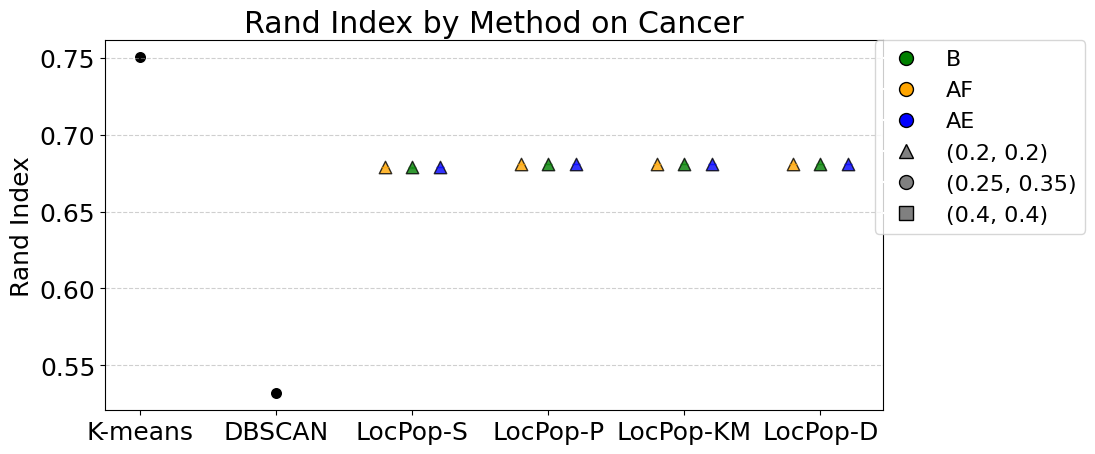

Figure saved as ./figures/Cancer-Silhouette Score.png


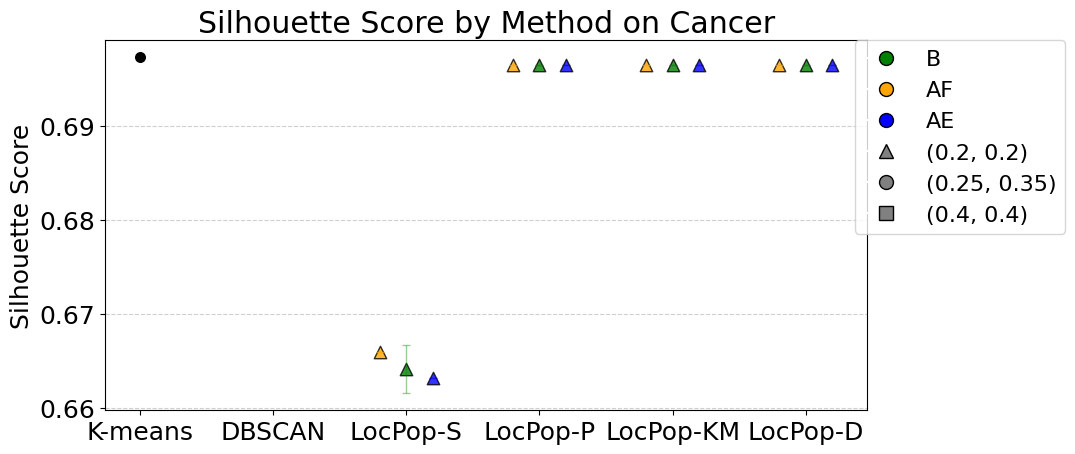

Figure saved as ./figures/Iris-Rand Index.png


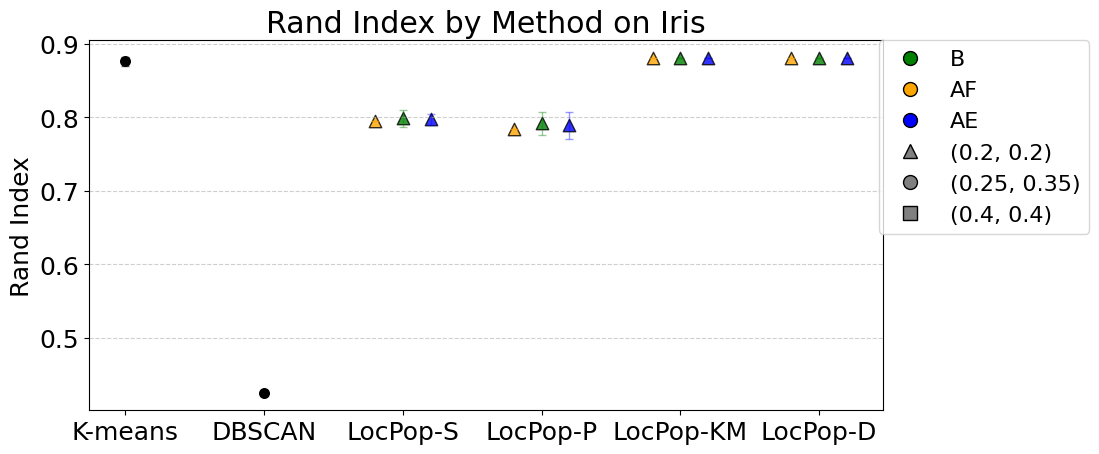

Figure saved as ./figures/Iris-Silhouette Score.png


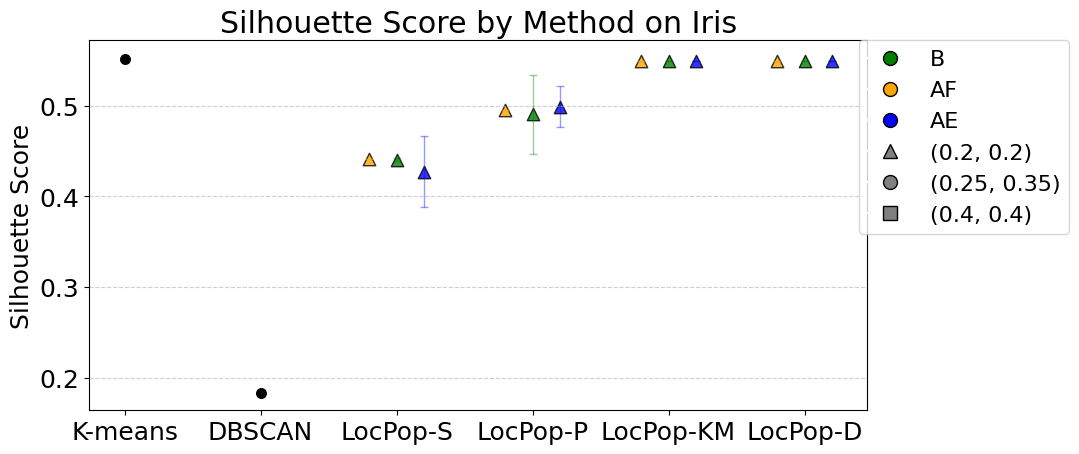

Figure saved as ./figures/Moons-Rand Index.png


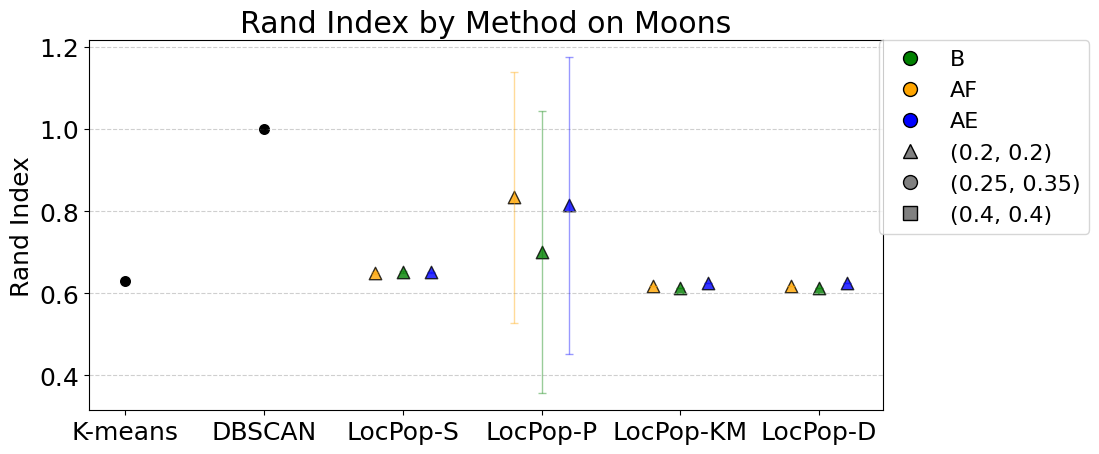

Figure saved as ./figures/Moons-Silhouette Score.png


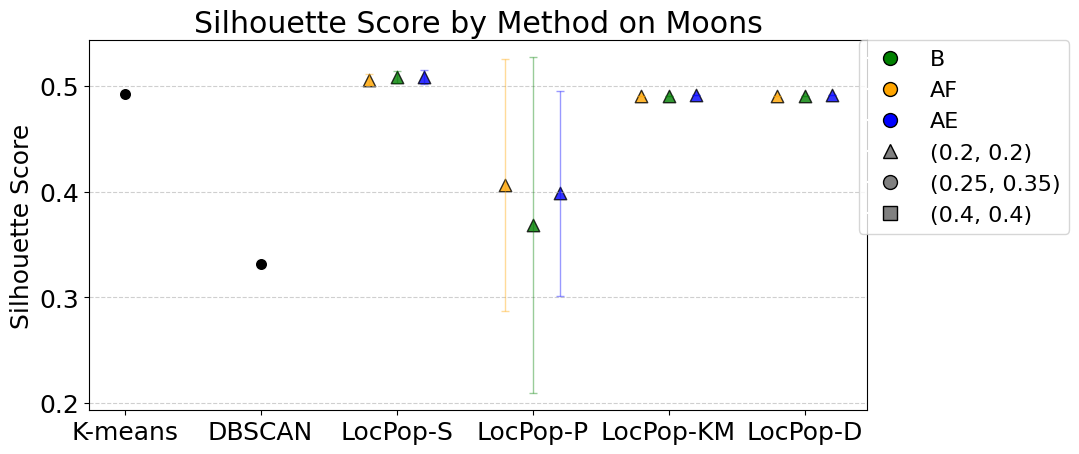

Figure saved as ./figures/3 Circles-Rand Index.png


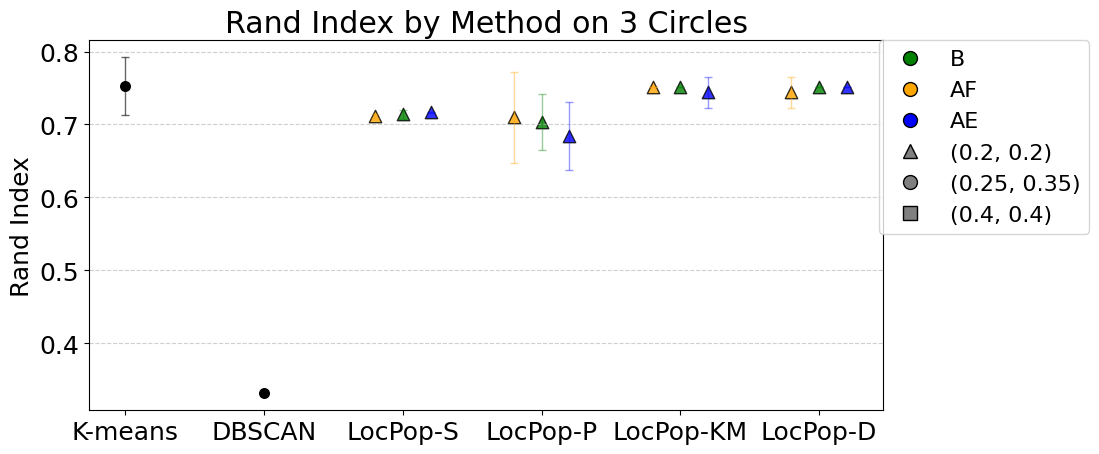

Figure saved as ./figures/3 Circles-Silhouette Score.png


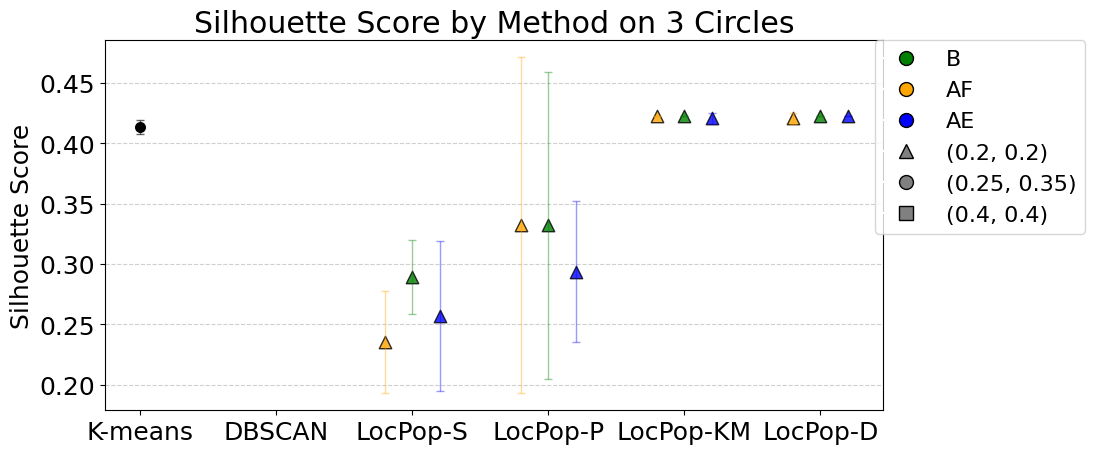

In [5]:
# Save and cleanup data
for i,df in enumerate(dfs):
    df.replace("n.A.", np.nan, inplace=True)
    df.to_csv(f'./csv/PopcularClustering/dataset-{i}.csv', index= False)
score_cols = ['Rand Index', 'Silhouette Score']
dfs = [normalize_score_column(df, score_cols) for df in dfs]
labels = [(0.2,0.2),(0.25,0.35),(0.4,.4)]
# Create figures
for Dataset in ['Cancer', 'Iris', 'Moons', '3 Circles']:
    for score in score_cols:
        plot_and_save(
            dfs, labels, Dataset, score,
            save_path=f'./figures/PopcularClustering/{Dataset}-{score}.png'
        )

In [6]:
dfs[0]

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering,Threshold
0,kmeans,Moons,"(0.6305239687848383, 0.0)","(0.49242898579116434, 5.551115123125783e-17)","(0.7730469424540499, 6.409875621278546e-17)","(0.03932916667933265, 0.05178776715167731)",NaN,"(0.2, 0.2)"
1,dbscan,Moons,"(1.0, 0.0)","(0.3311172304608083, 4.5324665183683945e-17)","(1.1512825783803178, 1.2819751242557092e-16)","(0.0020043999732782445, 9.972973196199775e-05)",NaN,"(0.2, 0.2)"
2,LP (Balanced) Heuristic starting with everyone...,Moons,"(0.6507617985878856, 0.001157322135106452)","(0.5080562843811768, 0.0028925080833101854)","(0.6053660794186668, 0.004849081662648015)","(3.9604151333138966, 0.3472331165010272)",NaN,"(0.2, 0.2)"
3,LP (Balanced) Heuristic starting with predicte...,Moons,"(0.6995466369379413, 0.1719308243471573)","(0.3679598303255133, 0.07956472787936794)","(1.241665624869923, 0.45113773523440565)","(0.31466023332905024, 0.02963692803386582)",NaN,"(0.2, 0.2)"
4,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6139130434782609, 0.0)","(0.4899815550606015, 0.0)","(0.7750582618830012, 9.064933036736789e-17)","(0.3000089666650941, 0.011224124955305479)","(0.50082497212932, 0.002311969925853395)","(0.2, 0.2)"
5,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6139130434782609, 0.0)","(0.4899815550606015, 0.0)","(0.7750582618830012, 9.064933036736789e-17)","(0.2940463999984786, 0.006650806993694979)",NaN,"(0.2, 0.2)"
6,LP (Friend-Oriented) Heuristic starting with e...,Moons,"(0.6498773690078038, 0.0013563680049587894)","(0.5059871862196834, 0.0025797963946637913)","(0.6088608804787875, 0.003455925753700284)","(3.8978606999929375, 0.13925661357395827)",NaN,"(0.2, 0.2)"
7,LP (Friend-Oriented) Heuristic starting with p...,Moons,"(0.833452248234857, 0.1529515849844168)","(0.40648120275502037, 0.05967136283808967)","(0.9588208040348327, 0.1307477518660356)","(0.2966555999979998, 0.003363826224675003)",NaN,"(0.2, 0.2)"
8,LP (Friend-Oriented) Heuristic starting with t...,Moons,"(0.6171460423634336, 0.0)","(0.4908692533659327, 5.551115123125783e-17)","(0.7739155600960933, 2.026980648162706e-16)","(0.3016984332740928, 0.00822490781032013)","(0.4988257153474545, 0.0004204276662573266)","(0.2, 0.2)"
9,LP (Friend-Oriented) Heuristic starting with t...,Moons,"(0.6171460423634336, 0.0)","(0.4908692533659327, 5.551115123125783e-17)","(0.7739155600960933, 2.026980648162706e-16)","(0.3017169666321327, 0.0038602659083231882)",NaN,"(0.2, 0.2)"
